<a href="https://colab.research.google.com/github/BlightG/Hopefield_net/blob/main/Hopfield_minst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [578]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import rotate

In [601]:
class HopfieldNetwork:
    def __init__(self, num_neurons=784):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))


    def train_pattern(self, patterns):
        for pattern in patterns:
            pattern = pattern.reshape(self.num_neurons, 1)
            self.weights += np.dot(pattern, pattern.T)

        np.fill_diagonal(self.weights, 0)


    def recall(self, pattern, steps=10, tolerance=1e-6):

        pattern = pattern.copy()
        previous_energy = self.energy(pattern)
        size = pattern.shape[0]

        for _ in range(steps):
            pattern = pattern.reshape(self.num_neurons, 1)
            pattern = np.sign(np.dot(self.weights, pattern))
            pattern = pattern.reshape((size, size))
            current_energy = self.energy(pattern)
            if abs(current_energy - previous_energy) < tolerance:
                break
            previous_energy = current_energy

        pattern = pattern.reshape(28, 28)
        return pattern

    def energy(self, pattern):
        #  - 0.5 time summation of all nodes of the pattern times the coresponding weights
        pattern = pattern.reshape(self.num_neurons, 1)
        return -0.5 * pattern.T @ self.weights @ pattern




In [602]:
class minst_dataset:

      def __init__(self):
        (x_train, y_train, x_test, y_test) = self.load_minst_data()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.train_dict = self.consturct_train_dict()

      def load_minst_data(self) -> tuple:
        """ Loads the training and testing data from minst"""
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        return (x_train, y_train, x_test, y_test)

      def consturct_train_dict(self) -> dict:
        """ Returns a dict with digits as index and coresponding training images as values """
        train_dict = {}
        for i in range(10):
            train_dict[i] = self.x_train[self.y_train == i]

        for i in train_dict.keys():
            train_dict[i] = random.choice(train_dict[i])
            threshold = np.mean(train_dict[i])
            train_dict[i] = np.where(train_dict[i] > threshold, 1 ,-1)
        return train_dict

In [603]:
class Hopfield_interface:
    def __init__(self):
        self.hopfield_network = HopfieldNetwork()
        self.minst_dataset = minst_dataset()
        self.pattern_index = []

    def train_network(self, first_digit=0, second_digit=2):
        """ trains the network on the given patterns """
        patterns = [self.minst_dataset.train_dict[first_digit],  self.minst_dataset.train_dict[second_digit]]
        self.pattern_index = [first_digit, second_digit]
        self.hopfield_network.train_pattern(patterns)

    def generate_test_pattern(self, number=0, distortion="salt_and_paper"):
      """ retrives a patter to test the hopefiled network on returns a 28*28 pattern"""
      if number not in range(10):
          Exception("Number must be between 0 and 9")
      pattern = self.minst_dataset.pick_pattern(number)
      threshold = np.mean(pattern)
      pattern = np.where(pattern > threshold, 1 ,-1)
      pattern = self.distort_pattern(pattern, distortion)
      return pattern

    def pattern_match(self, pattern):
      return self.hopfield_network.recall(pattern)

    def distort_pattern(self, pattern, distortion="invert_pixels"):
      """ applies salt_and_pepper noise to the pattern returns 28 * 28 array """
      distortions = {
        "gaussian_noise": Distortion.add_gaussian_noise,
        "invert_pixels": Distortion.invert_random_pixels,
        "salt_and_pepper": Distortion.add_salt_and_pepper_noise
      }

      if distortion in distortions:
          pattern = distortions[distortion](pattern)
      else:
         Exception('Invalid distortion provided')
      return pattern

    def pick_pattern(self):
        """ returns a random pattern from the minst training set"""
        number = random.choice(self.pattern_index)
        return random.choice(self.minst_dataset.x_test[self.minst_dataset.y_test == number])


In [604]:
import numpy as np

class Distortion:

    @classmethod
    def add_salt_and_pepper_noise(cls, pattern, amount=0.1):
      """
      Adds salt-and-pepper noise to an pattern.
      - pattern: 2D array (binary pattern).
      - amount: Proportion of pixels to be flipped.
      """
      noisy_pattern = pattern.copy()
      # Generate random indices for salt and pepper
      num_salt = int(amount * pattern.size / 2)
      salt_indices = tuple(np.random.randint(0, i, num_salt) for i in pattern.shape)
      num_pepper = int(amount * pattern.size / 2)
      pepper_indices = tuple(np.random.randint(0, i, num_pepper) for i in pattern.shape)

      # Apply salt and pepper noise
      noisy_pattern[salt_indices] = 1
      noisy_pattern[pepper_indices] = -1
      return noisy_pattern

    @classmethod
    def add_gaussian_noise(cls, pattern, mean=-0.01, std=0.1):
      """
      Adds Gaussian noise to an pattern.
      - pattern: 2D array (binary pattern).
      - mean: Mean of the Gaussian distribution.
      - std: Standard deviation of the Gaussian distribution.
      """
      noisy_pattern = pattern.copy()
      gaussian_noise = np.random.normal(mean, std, pattern.shape)
      noisy_pattern = noisy_pattern + gaussian_noise

      # Binarize again (optional)
      noisy_pattern = np.where(noisy_pattern > 0, 1, -1)
      return noisy_pattern

    @classmethod
    def invert_random_pixels(cls, pattern, amount=0.5):
      """
      Randomly inverts pixels in a binary pattern.
      - pattern: 2D array (binary pattern).
      - amount: Proportion of pixels to invert.
      """
      noisy_pattern = pattern.copy()
      num_pixels_to_invert = int(amount * pattern.size)
      indices = tuple(np.random.randint(0, i, num_pixels_to_invert) for i in pattern.shape)

      # Invert selected pixels
      noisy_pattern[indices] = -noisy_pattern[indices]
      return noisy_pattern

In [613]:
interface = Hopfield_interface()

In [614]:
interface.train_network()

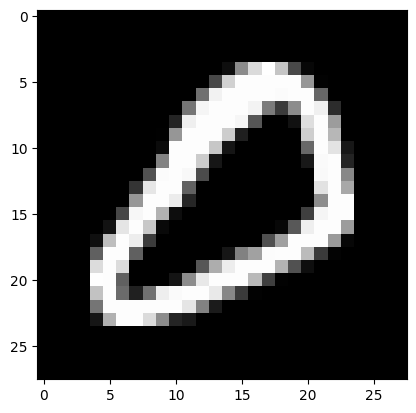

In [618]:
pattern = interface.pick_pattern() # picks a pattern from the digits network was trained on
plt.imshow(pattern, cmap='gray')

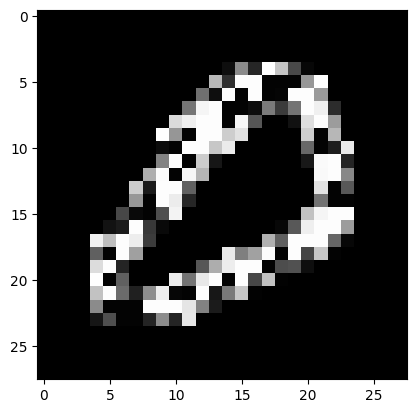

In [619]:
distorted_pattern = interface.distort_pattern(pattern) # distorts pciked pattern can take string arugment to use different distortions
plt.imshow(distorted_pattern, cmap='gray')

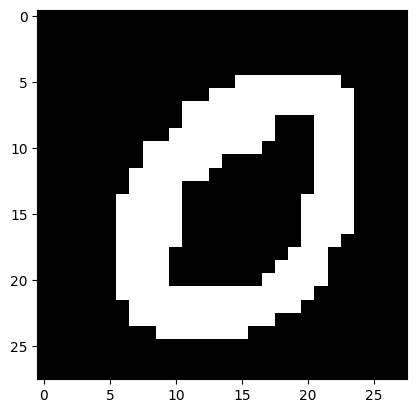

In [620]:
retrived_pattern = interface.pattern_match(distorted_pattern) # the stable pattern from the network
plt.imshow(retrived_pattern, cmap='gray')